In [1]:
import tensorflow as tf
from tensorflow import keras

DATASET_DIR= r'C:/Users/Gourab Paul/CollegeProject/tomato'
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3
IMAGE_SHAPE=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
NUM_CLASSES=10

In [2]:
train_ds = keras.utils.image_dataset_from_directory(
    F"{DATASET_DIR}/train",
    validation_split=0.2,
    subset="training",
    # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
)

val_ds = keras.utils.image_dataset_from_directory(
    F"{DATASET_DIR}/train",
    validation_split=0.2,
    subset="validation",
    # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [3]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    # keras.layers.RandomBrightness(0.4),
    keras.layers.RandomContrast(0.4),
])

In [4]:
preprocessing = keras.Sequential([
    # keras.layers.Reshape(IMAGE_SHAPE),
    keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    keras.layers.Rescaling(1./255),
])

In [5]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None,None,3)),

    preprocessing,
    # data_augmentation,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.GlobalAveragePooling2D(),
    
    # tf.keras.layers.Flatten(),

    # keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    # keras.layers.Dense(128, activation="relu"),
    # keras.layers.Dropout(0.4),

    keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(expand_nested=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 128, 128, 3)       0         |
|                                                               |
| rescaling (Rescaling)     (None, 128, 128, 3)       0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

In [7]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    # steps_per_epoch=train_ds.samples/train_ds.batch_size,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop]
    # validation_steps=validation_ds.samples/validation_ds.batch_size
)

Epoch 1/300
250/250 [==============================] - 39s 148ms/step - loss: 1.9829 - sparse_categorical_accuracy: 0.2645 - val_loss: 1.6748 - val_sparse_categorical_accuracy: 0.3780
Epoch 2/300
250/250 [==============================] - 42s 167ms/step - loss: 1.4786 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.2202 - val_sparse_categorical_accuracy: 0.5880
Epoch 3/300
250/250 [==============================] - 37s 149ms/step - loss: 1.2070 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.0286 - val_sparse_categorical_accuracy: 0.6765
Epoch 4/300
250/250 [==============================] - 42s 169ms/step - loss: 1.0084 - sparse_categorical_accuracy: 0.6351 - val_loss: 0.8960 - val_sparse_categorical_accuracy: 0.6835
Epoch 5/300
250/250 [==============================] - 24s 96ms/step - loss: 0.8734 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.8410 - val_sparse_categorical_accuracy: 0.6915
Epoch 6/300
250/250 [==============================] - 15s 58ms/step - loss: 0.78

In [8]:
test_ds = keras.utils.image_dataset_from_directory(
    F"{DATASET_DIR}/val",
    # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)
results = model.evaluate(test_ds, verbose=0)
print("test accuracy:", results[1]*100)
print("test loss:", results[0]*100)

Found 1000 files belonging to 10 classes.
test accuracy: 96.60000205039978
test loss: 10.2330781519413


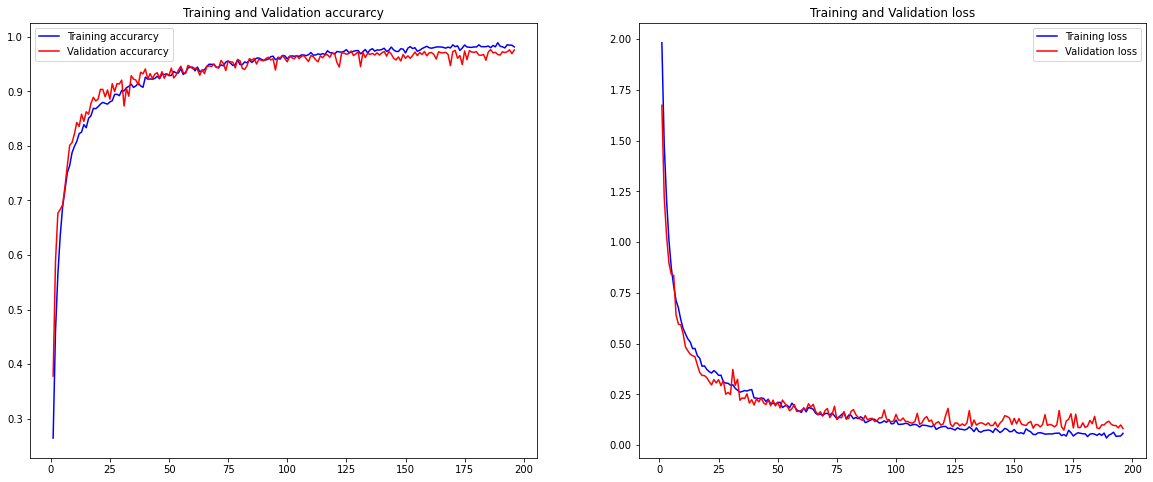

In [9]:
from matplotlib import pyplot as plt

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
# plt.ylim((0, 1))
plt.plot(epochs, acc, "b",label="Training accurarcy")
plt.plot(epochs, val_acc, "r", label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [15]:
import numpy as np
import tensorflow_datasets as tfds

correct = 0
inCorrect = 0
classNames = [
    "Tomato___Bacterial_spot", 
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
]

def predict(image, label):
    result = model.predict(image)
    predictedClass = classNames[result.argmax()]

    boolResult = False
    if str(classNames[label]) == predictedClass:
        boolResult = True
    # print(f"\n{classNames[label]} --- Label {label} --- Result {predictedClass} --- Correct?? {boolResult}")
    return boolResult

valDS = keras.utils.image_dataset_from_directory(
    F"{DATASET_DIR}/val",
    # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    shuffle=True,
)

for image, label in valDS:
    result = predict(image, label[0])
    if(result==True):
        correct += 1
    else:
        inCorrect += 1
    # break
print(f"\n[INFO] Correct ---> {correct}           InCorrect ---> {inCorrect}")

Found 1000 files belonging to 10 classes.

[INFO] Correct ---> 966           InCorrect ---> 34


In [14]:
# model.save('tomato_feel_bad(32,64,128_GA,D20)_E196.h5')